In [1]:
import numpy as np
import pandas as pd
import nltk
import pickle

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
df = pd.read_csv('../data/Suicide_Detection.csv')
df=df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


In [3]:
for col in df.columns:
    print(type(df[col][0]), col)
 
print('Classes are balanced')    
print(df['class'].value_counts())

<class 'str'> text
<class 'str'> class
Classes are balanced
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


In [4]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)
suicide_rows = df[df['class'] == 'suicide']
non_suicide_rows = df[df['class'] == 'non-suicide']

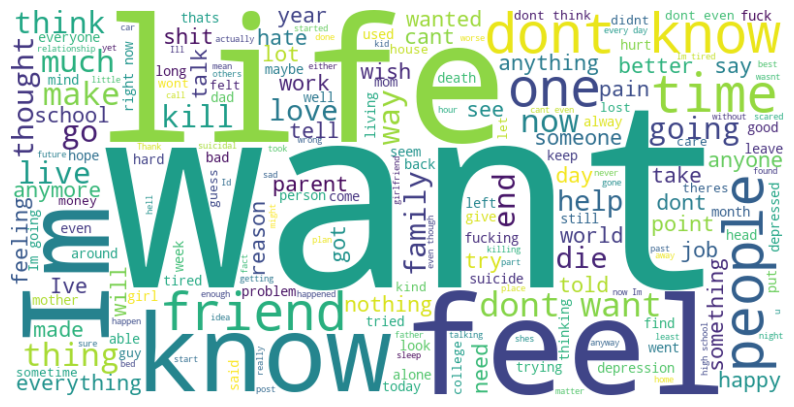

In [64]:
#suicide_rows['text']
all_text = ''.join(suicide_rows['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

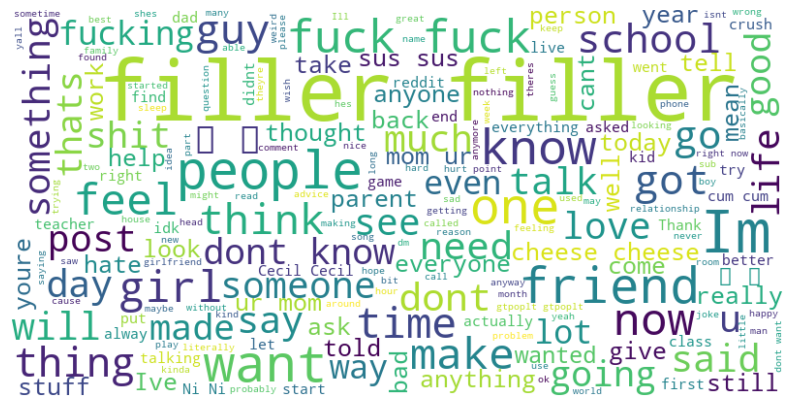

In [53]:
all_text = ''.join(non_suicide_rows['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
words_to_find = ["want", "life", "feel", "suicide", "need", "talk", "people"]
occurrences_suicide = []
occurrences_non_suicide = []

for word in words_to_find:
    word_frequency_suicide = suicide_rows['text'].apply(lambda x: x.split().count(word)).sum()
    occurrences_suicide.append(word_frequency_suicide)

    word_frequency_non_suicide = non_suicide_rows['text'].apply(lambda x: x.split().count(word)).sum()
    occurrences_non_suicide.append(word_frequency_non_suicide)


In [78]:
import pandas as pd
data = {'words': words_to_find, 'occurrences_suicide': occurrences_suicide, 'occurrences_non_suicide': occurrences_non_suicide}
summary_df = pd.DataFrame(data=data)
summary_df

,words,occurrences_suicide,occurrences_non_suicide
0,want,127104,20143
1,life,106606,8830
2,feel,107149,14250
3,suicide,32331,773
4,need,28545,10438
5,talk,27715,9124
6,people,67216,20379


In [5]:
df['text']= df['text'].str.lower()

In [6]:
class_labels = (df['class']=='suicide').astype('int') # { 1 => Suicide, 0 => Non-Suicide }

## PreProcessing

In [7]:
texts = df['text']
train_size = int(0.8 * len(texts))

train_text = df['text'][:train_size]
train_labels = class_labels[:train_size]

test_text = df['text'][train_size:]
test_labels = class_labels[train_size:]

validation_size = int(0.8 * len(train_text))

validation_text = train_text[validation_size:]
validation_labels = train_labels[validation_size:]

train_text = train_text[:validation_size]
train_labels = train_labels[:validation_size]

In [8]:
print(len(train_text), len(train_labels))
print(len(test_text), len(test_labels))
print(len(validation_text), len(validation_labels))

148527 148527
46415 46415
37132 37132


In [30]:
for i in range(20):
    print(len(train_text[i]))

715
138
129
41
2426
1479
1183
47
945
1116
145
442
204
730
36
101
1009
129
74
377


In [31]:
train_text[4]

'i’m so losthello, my name is adam (16) and i’ve been struggling for years and i’m afraid. through these past years thoughts of suicide, fear, anxiety i’m so close to my limit . i’ve been quiet for so long and i’m too scared to come out to my family about these feelings. about 3 years ago  losing my aunt triggered it all. everyday feeling hopeless , lost, guilty, and remorseful over her and all the things i’ve done in my life,but thoughts like these with the little i’ve experienced in life? only time i’ve revealed these feelings to my family is when i broke down where they saw my cuts. watching them get so worried over something i portrayed as an average day made me feel absolutely dreadful. they later found out i was an attempt survivor from attempt od(overdose from pills) and attempt hanging. all that happened was a blackout from the pills and i never went through with the noose because i’m still so afraid. during my first therapy i was diagnosed with severe depression, social anxiet

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
train_text_tokenized = []
max_length = 1024

for row in train_text:
    encoded_text = tokenizer.encode(row, max_length=max_length, truncation=True)
    train_text_tokenized.append(encoded_text)
    
test_text_tokenized = []
for row in test_text:
    encoded_text = tokenizer.encode(row, max_length=max_length, truncation=True)
    test_text_tokenized.append(encoded_text)
    
validation_text_tokenized = []
for row in validation_text:
    encoded_text = tokenizer.encode(row, max_length=max_length, truncation=True)
    validation_text_tokenized.append(encoded_text)


In [10]:
# Pad sequences to a fixed length
train_text_padded = pad_sequences(train_text_tokenized, 
                    maxlen=max_length, padding='post', truncating='post', value=0)

test_text_padded = pad_sequences(test_text_tokenized, 
                    maxlen=max_length, padding='post', truncating='post', value=0)

validation_text_padded = pad_sequences(validation_text_tokenized, 
                    maxlen=max_length, padding='post', truncating='post', value=0)

In [11]:
train_text_padded = np.array(train_text_padded)
train_labels = np.array(train_labels)

test_text_padded = np.array(test_text_padded)
test_labels = np.array(test_labels)

validation_text_padded = np.array(validation_text_padded)
validation_labels = np.array(validation_labels)

In [12]:
train_text_padded.shape

(148527, 1024)

In [14]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(max_length,), dtype=tf.int32))

model.add(tf.keras.layers.Dense(128, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.L2(0.01),input_shape=(1024,)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128, activation='relu', 
        kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64, 
        activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(64, 
        activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_text_padded, train_labels, 
                    epochs=16, batch_size=128, 
                    validation_data=(validation_text_padded, validation_labels))

Epoch 1/16
1161/1161 [==============================] - 18s 16ms/step - loss: 0.6582 - accuracy: 0.7274 - val_loss: 0.6562 - val_accuracy: 0.7268
Epoch 2/16
1161/1161 [==============================] - 17s 15ms/step - loss: 0.6402 - accuracy: 0.7300 - val_loss: 0.6139 - val_accuracy: 0.7287
Epoch 3/16
1161/1161 [==============================] - 17s 15ms/step - loss: 0.6945 - accuracy: 0.7309 - val_loss: 0.7722 - val_accuracy: 0.7351
Epoch 4/16
1161/1161 [==============================] - 17s 14ms/step - loss: 0.7208 - accuracy: 0.7320 - val_loss: 0.6801 - val_accuracy: 0.7359
Epoch 5/16
1161/1161 [==============================] - 16s 13ms/step - loss: 0.6813 - accuracy: 0.7326 - val_loss: 0.6595 - val_accuracy: 0.7328
Epoch 6/16
1161/1161 [==============================] - 16s 14ms/step - loss: 0.6526 - accuracy: 0.7321 - val_loss: 0.6208 - val_accuracy: 0.7398
Epoch 7/16
1161/1161 [==============================] - 14s 12ms/step - loss: 0.6372 - accuracy: 0.7322 - val_loss: 0.6357 -

In [19]:
loss, accuracy = model.evaluate(test_text_padded, test_labels)

1451/1451 [==============================] - 6s 4ms/step - loss: 0.5788 - accuracy: 0.7398


In [21]:
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.7397608757019043


In [54]:
preds = model.predict(test_text_padded)
#preds = (preds >= 0.7).astype(int)

1451/1451 [==============================] - 7s 4ms/step


<Axes: >

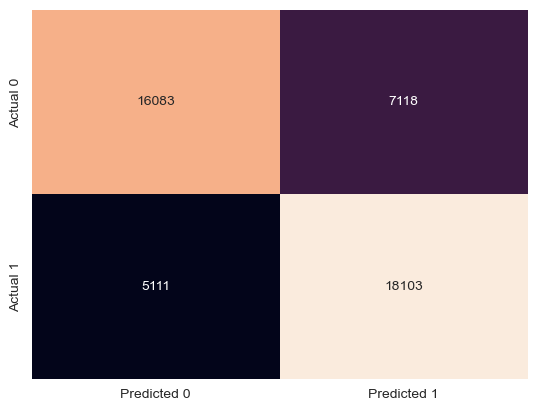

In [62]:
import seaborn as sns

cm = tf.math.confusion_matrix(
    test_labels,
    preds,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
            

In [63]:
TP = 18103
TN = 16083
FP = 7118
FN = 5111

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)

print('sensitivity / Recall / True Positive Rate:  ', sensitivity)
print('specificity / True Negative Rate:           ', specificity)
print('False Positive Rate:                        ', 1 - specificity)
print('Positive Predictive Value / Precision:      ', PPV)
print('Negative Predictive Value:                  ', NPV)

sensitivity / Recall / True Positive Rate:   0.779831136383217
specificity / True Negative Rate:            0.693202879186242
False Positive Rate:                         0.306797120813758
Positive Predictive Value / Precision:       0.7177748701478927
Negative Predictive Value:                   0.7588468434462584


In [60]:
preds = model.predict(test_text_padded)
preds = (preds >= 0.45).astype(int)

1451/1451 [==============================] - 6s 4ms/step


In [61]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72     23201
           1       0.72      0.78      0.75     23214

    accuracy                           0.74     46415
   macro avg       0.74      0.74      0.74     46415
weighted avg       0.74      0.74      0.74     46415
